# Machine Learning Assignment 2: Road Sign Classification

To begin, we will open extract the provided dataset and perform some initial exploratory data analysis.

In [81]:
import zipfile
with zipfile.ZipFile('./trafficsigns_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [82]:
import os
import numpy as np
import pandas as pd

data_folder_name = "trafficsigns_dataset"
data_dir = data_folder_name
file_count = sum(len(files) for _, _, files in os.walk(data_dir))

print("Total number of images:", file_count)

Total number of images: 3699


We will place all the images into a pandas dataframe and perform some exploratory data analysis.

In [83]:
#Getting all class labels
shapes = os.listdir(data_folder_name)

types = []

#To be used as pd dataframe
data = []


# 1. Iterator for all shapes in the folder
# 2. For each shape, access it's folder and iterate for all of it's types
# 3. For each of the types exist images. Create an entry for each image, keeping track of it's shape and type.
# 4. Add the given entry to the data and loop until everything has been added to the data array.
# 5. Convert the data array into a pandas dataframe.

for current_shape in shapes:
    current_directory = os.path.join(data_folder_name, current_shape)
    shape_types = os.listdir(current_directory)
    
    for current_type in shape_types:
        current_shape_type_directory = os.path.join(current_directory, current_type)
        
        for images in os.listdir(current_shape_type_directory):
            current_image = os.path.join(current_shape_type_directory, images)
            entry = [current_image, current_shape, current_type]
            data.append(entry)
            
data = pd.DataFrame(data, columns = ['ImgPath', 'Shape', 'Type'])

We will view all the columns:

In [84]:
data_shape = data['Shape'].unique()
data_type = data['Type'].unique()

print("-" * 50)

print("Shapes:")
for shape in data_shape:
    print("\t", shape)

print("-" * 50)
    
print("Types:")
for shape_type in data_type:
    print("\t", shape_type)
    
print("-" * 50)

--------------------------------------------------
Shapes:
	 diamond
	 hex
	 round
	 square
	 triangle
--------------------------------------------------
Types:
	 rightofway
	 stop
	 bicycle
	 limitedtraffic
	 noentry
	 noparking
	 roundabout
	 speed
	 trafficdirective
	 traveldirection
	 continue
	 crossing
	 laneend
	 parking
	 giveway
	 warning
--------------------------------------------------


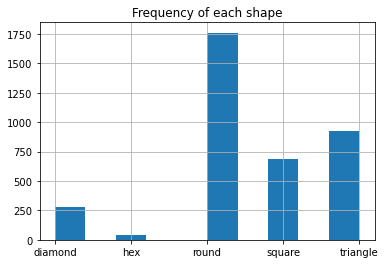

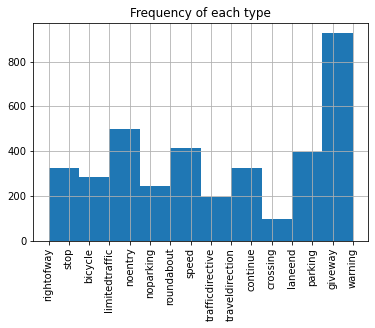

In [85]:
#Visualize number of values for each shape

data.Shape.hist()
plt.title("Frequency of each shape")
plt.show()

#Visualize number of values for each type

data.Type.hist()
plt.xticks(rotation='vertical')
plt.title("Frequency of each type")
plt.show()

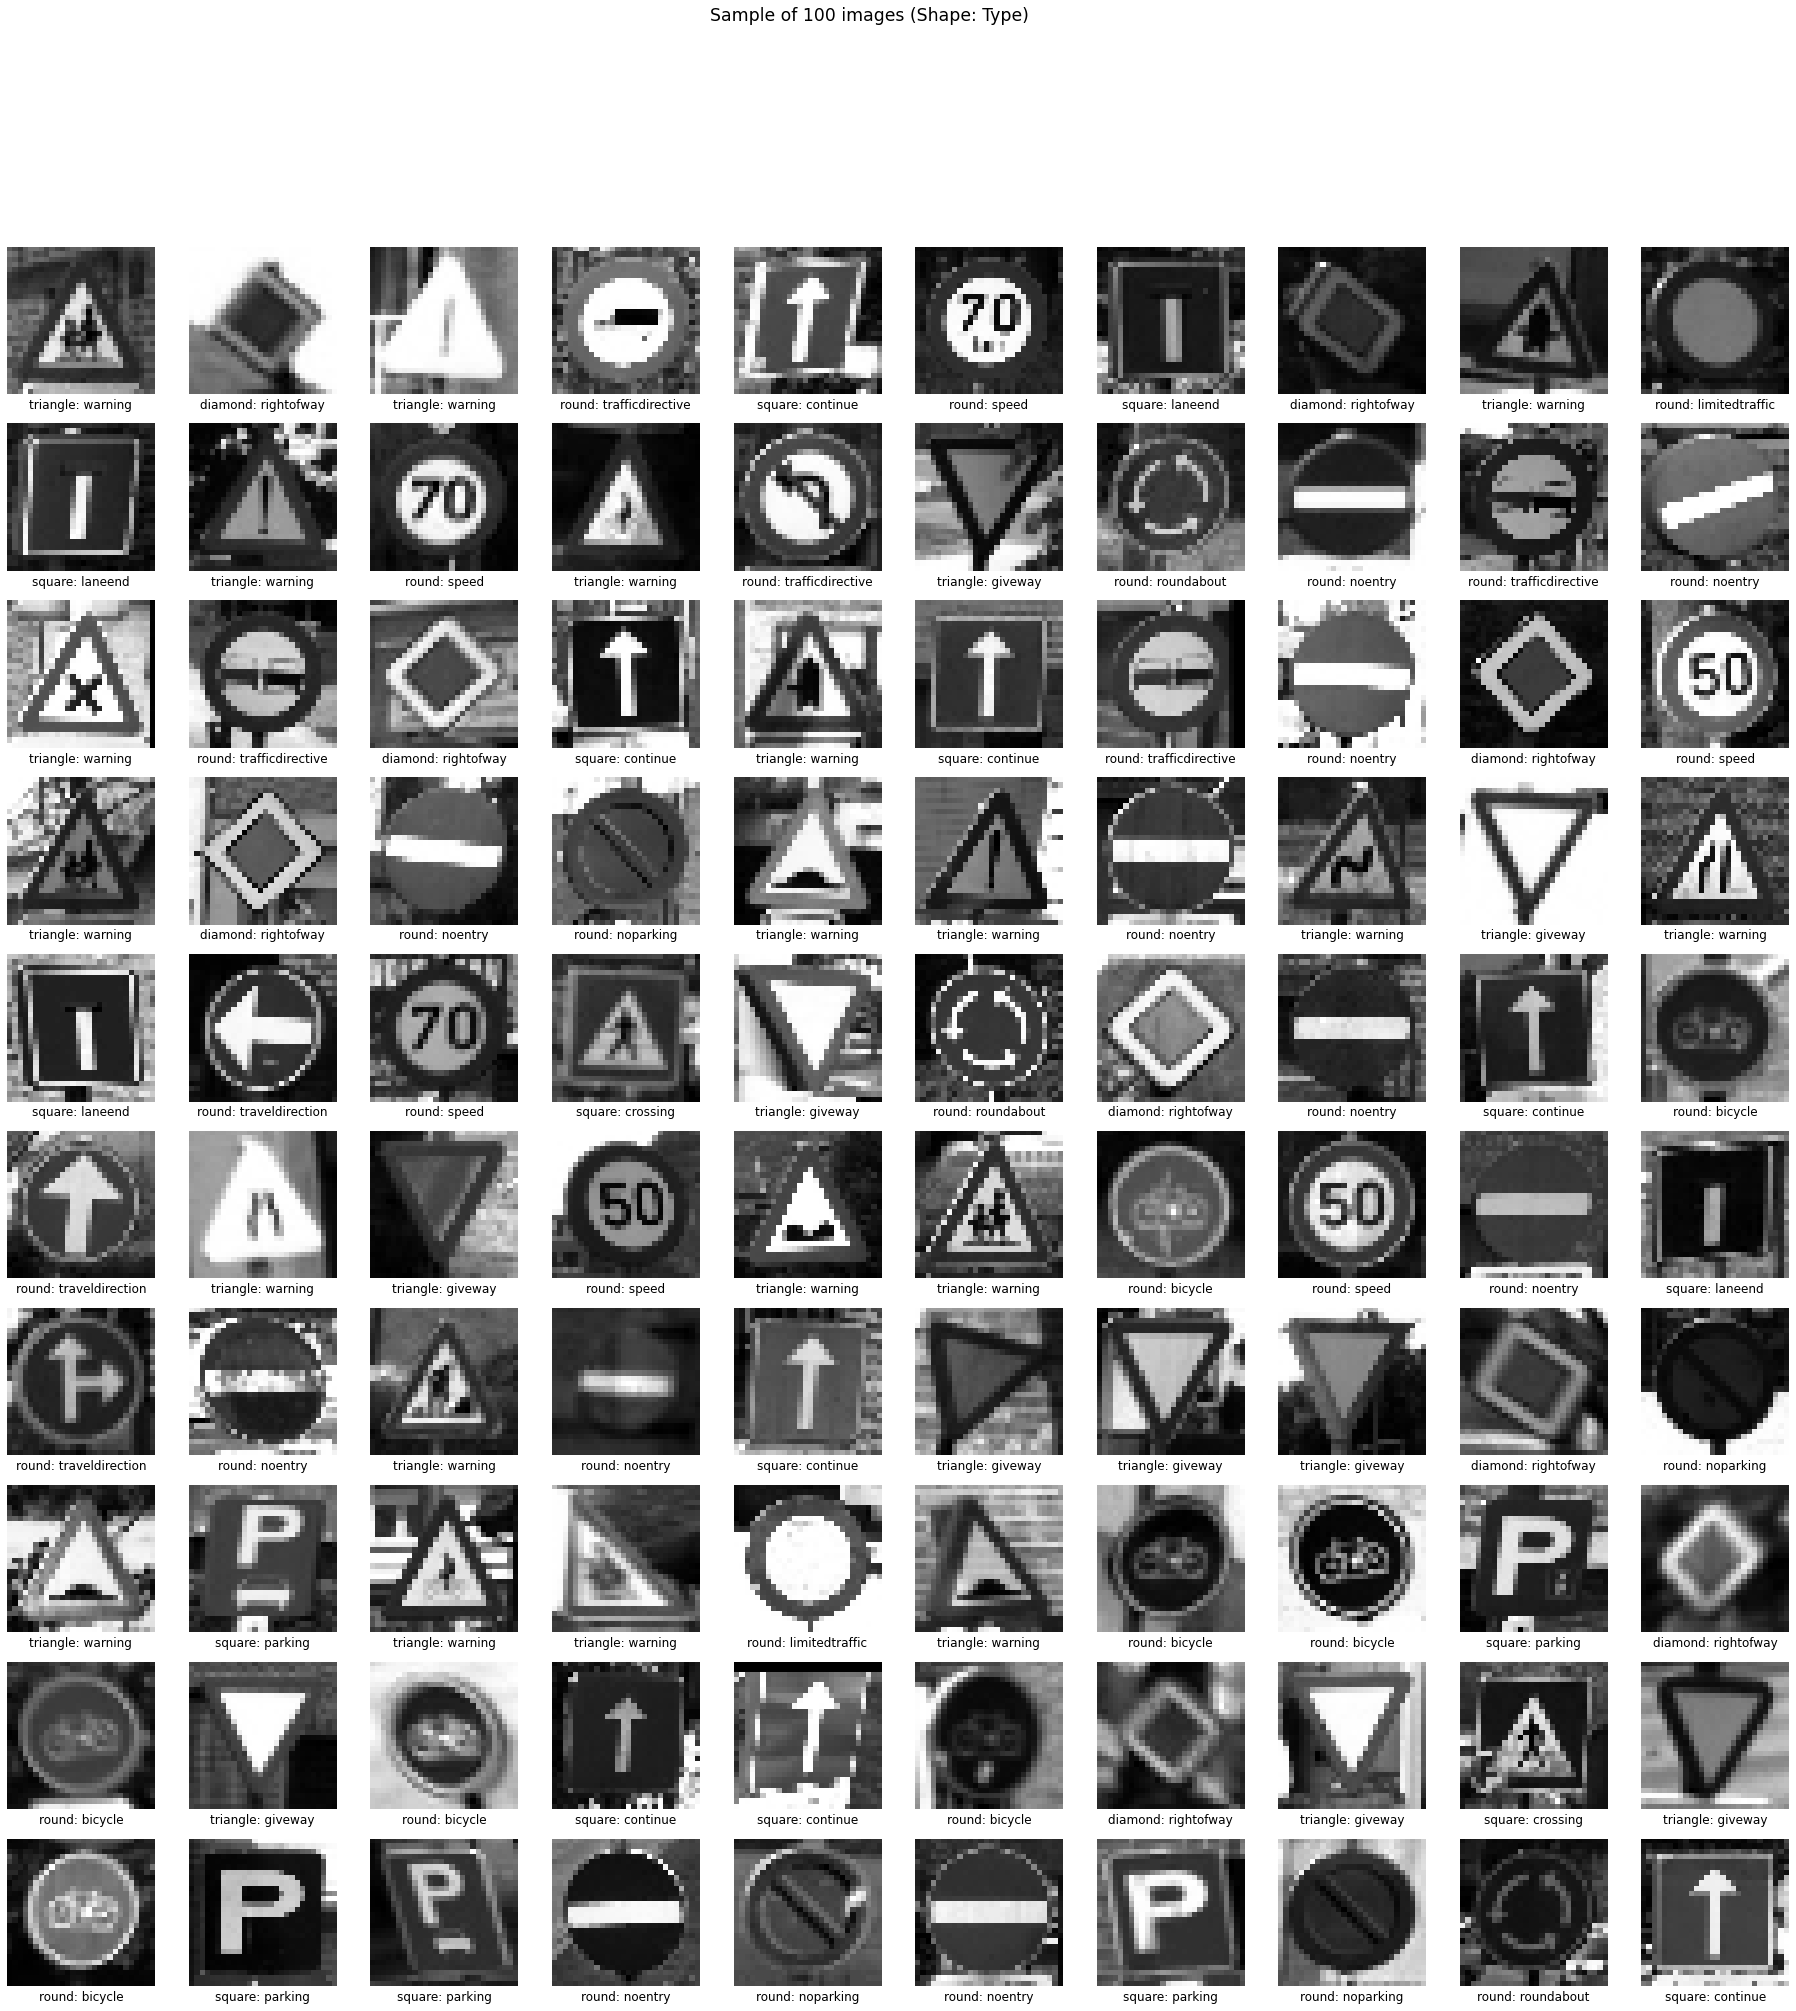

In [86]:
#Plotting Random images

from PIL import Image

r_inx = np.random.choice(data.shape[0], 100)
rand_data = data.loc[r_inx, 'ImgPath']

#Sampling of 100 random images
plt.figure(figsize=(32,32))
plt.suptitle("Sample of 100 images (Shape: Type)", ha='center', va='center', fontsize='xx-large')
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    ax1 = plt.subplot(10,10,i+1)
    ax1.imshow(im,cmap='gray')
    ax1.axis('off')
    ax1.text(0.5,-0.1, data['Shape'].iloc[r_inx[i]] + ": " +
                        data['Type'].iloc[r_inx[i]], size=12, ha="center", 
         transform=ax1.transAxes)

plt.show()

In [87]:
# Splitting the dataset into the training and validation and testing data

from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size = 0.25)
train_data, val_data = train_test_split(train_data, test_size = 0.25)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))
print("Total number of images: {}".format(train_data.shape[0] + val_data.shape[0] + test_data.shape[0]))

Train data : 2080, Val Data: 694, Test Data: 925
Total number of images: 3699


In [92]:
#Mapping categorical values to numerics

d = {'diamond' : 0, 'round' : 1, 'hex' : 2, 'square' : 3, 'triangle' : 4}
data['Shape'] = data['Shape'].map(d, na_action='ignore')

In [187]:
# We will define some base parameters to use for the neural networks (as we are using multilayer perceptrons with a hidden layer)

#The input dimension is 28x28x3 as the given dataset consists of greyscale, 2d images where each has a resolution of 28x28
#pixels each.
INPUT_DIM = (28, 28, 3)

#Hidden layer is arbitrarily set to 128 for now, but will be tuned later
HIDDEN_LAYER_DIM = 256

# The output classes will firstly be limited to 5 to test the neural network in detecting a given sign's shape
OUTPUT_CLASSES = 5

epochs = 50

In [135]:
#Using a function to plot the curvature of the algorithm so we can determine how to adjust it for better accuracy later on

import matplotlib.pyplot as plt

def plot_learning_curve(model):

    acc = model.history['categorical_accuracy']
    val_acc = model.history['val_categorical_accuracy']

    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(16, 16))
    plt.subplot(2, 1, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Loss')
    plt.show()

In [95]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

tf.__version__

'2.9.0'

In [101]:
#Using the sequential API, we will firstly create the base model, which consists of flattening the input shape into a large 1-dimensional value.
#In doing so, we generate the baseline model:
#
# FLATTENED INPUTS (28 * 28 * 3) -> HIDDEN LAYER PERCEPTRONS -> OUTPUT VALUES

shape_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [102]:
shape_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 2352)              0         
                                                                 
 dense_14 (Dense)            (None, 256)               602368    
                                                                 
 dense_15 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 603,653
Trainable params: 603,653
Non-trainable params: 0
_________________________________________________________________


In [103]:
#Compilation of the model

shape_model.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [106]:
# Passing the training data into the model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load images via dataframe using the flow_from_dataframe keras function

train_data['Shape'] = train_data['Shape'].astype('str')
val_data['Shape'] = val_data['Shape'].astype('str')

train_datagen = ImageDataGenerator(data_format='channels_last')
val_datagen = ImageDataGenerator(data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./',
        x_col="ImgPath",
        y_col="Shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./',
        x_col="ImgPath",
        y_col="Shape",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 2080 validated image filenames belonging to 5 classes.
Found 694 validated image filenames belonging to 5 classes.


In [108]:
# Train the model

history = shape_model.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=epochs, 
                                    verbose=0)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_14408/1720885406.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = shape_model.fit_generator(train_generator,


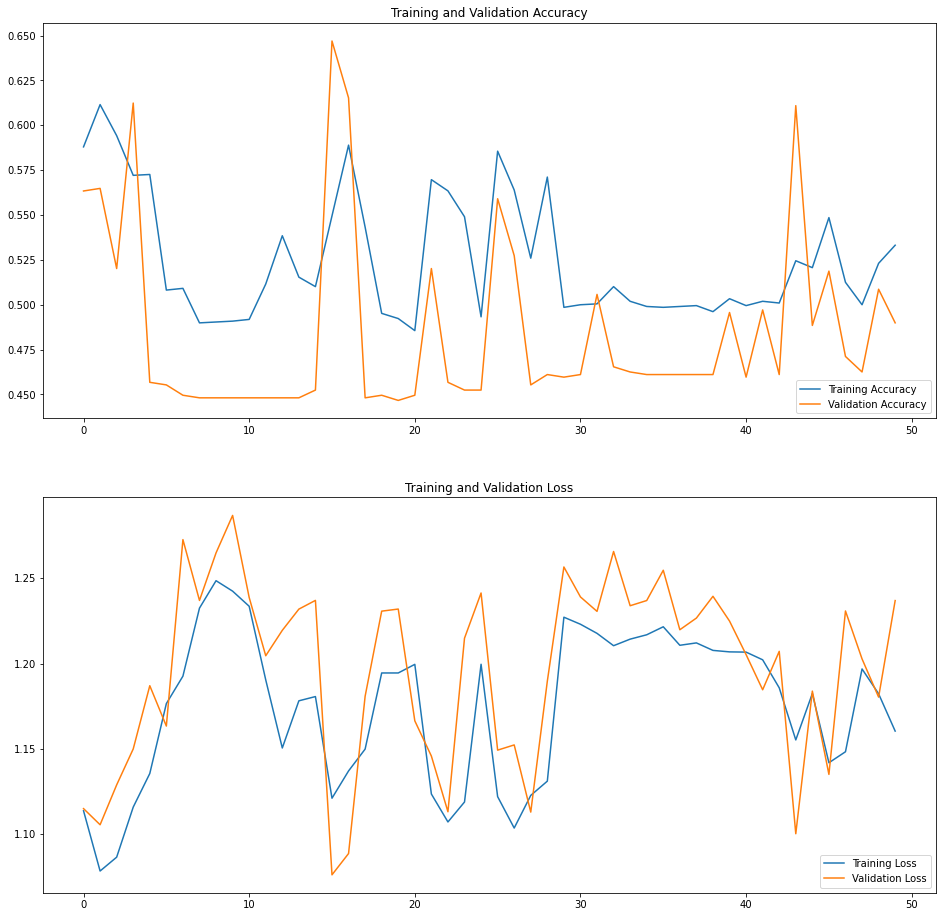

In [141]:
# Graph the loss and accuracy 

plot_learning_curve(history)

The loss function is relatively well-performing (1.00 - 1.25 range) whileas accuracy can be worked on. Both the training and validation accuracy sit in the 0.55-0.60 range, which can be improved on. Likewise, the validation data's accuracy fluctuates considerably, which similarly can be tuned to have a lower displacement between training and validation accuracy. 

We will test adding a ridge penalty of small lambda value. By doing so, we reduce contribution of variables with minimal contribution to the resulting output.

In [137]:
#This function adds ridge penalty (variables with minor contribution to outcome are close to 0)

reg_lambda = 0.01

shape_model_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', 
    kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

In [138]:
shape_model_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [139]:
history_reg = shape_model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_14408/3641511967.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_reg = shape_model_reg.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


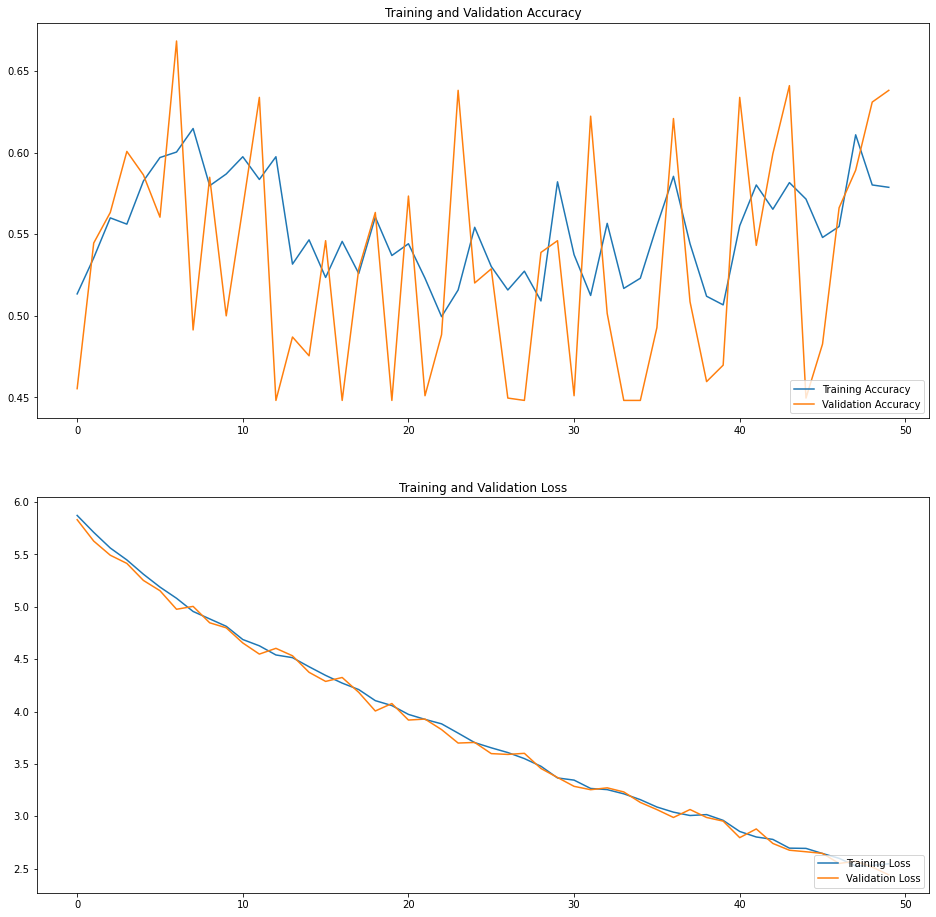

In [140]:
plot_learning_curve(history_reg)

Although the loss function's training and validation values have converged to be relatively the same, the actual values are much higher. Despite such, the epoch value can be adjusted as through the graph, it is evident that as more passes are inputted, the loss gradually decreases. 

The accuracy of the regularized model appears to be flunctuating at the same accuracy range as the baseline model. Regardless if the epoch value were to increase, the accuracy will remain relatively the same.

Regularizing the model thus proves to provide minimal contribution to the accuracy of the model, our model metric.

We will apply dropout some dropout to the model to reduce the small overfit in the baseline model.

In [155]:
#Dropout to reduce overfitting and compare if it results in a better model than just the regularized model (as the regularized
#model is already fairly good)

reg_lambda = 0.01

model_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [156]:
model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [157]:
history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_14408/2639068561.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)


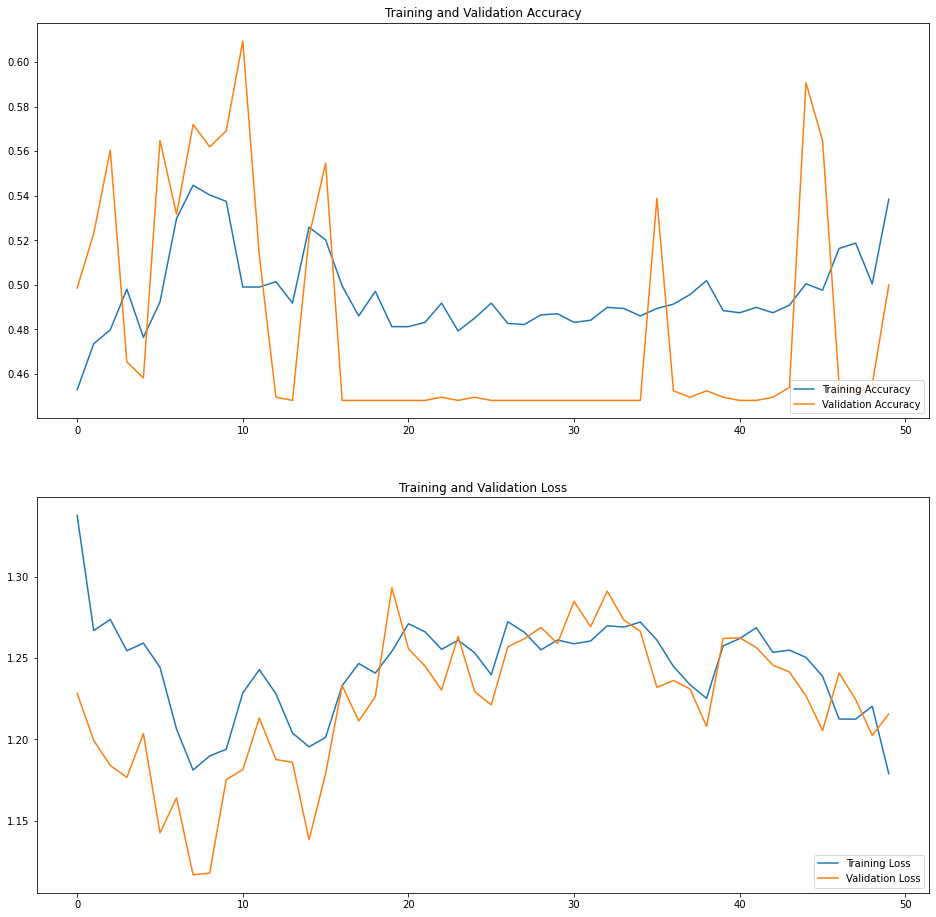

In [158]:
plot_learning_curve(history_drop)

The loss function appears more stabilised in comparison to the baseline model. Similarly, the accuracy although still relatively unchanged, is now displaying less displacement between the training and validation data. 

We will create a function that tests on multiple dropout values to see how the values change with different inputs.

In [159]:
def drop_param(dropout_value):
    reg_lambda = 0.01

    model_drop = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=INPUT_DIM),
        tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
        tf.keras.layers.Dropout(dropout_value),
        tf.keras.layers.Dense(OUTPUT_CLASSES)
    ])

    model_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

    history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)

    plot_learning_curve(history_drop)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_14408/799181565.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)


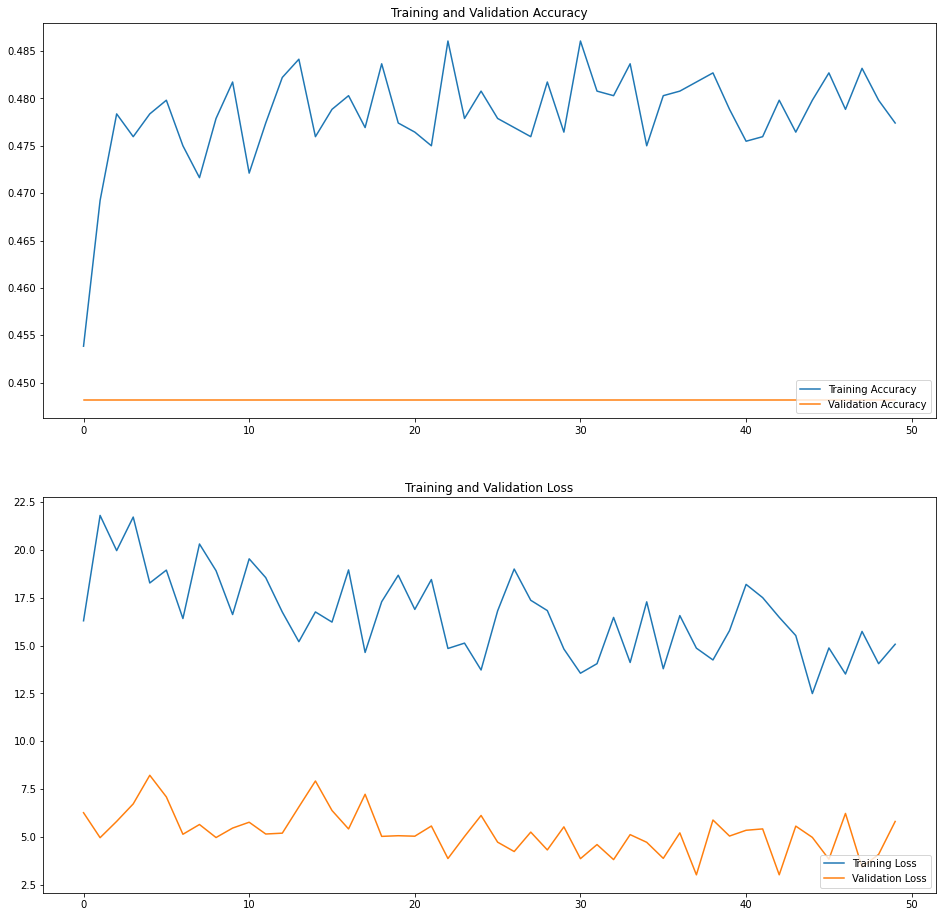

In [163]:
drop_param(0.999)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_14408/799181565.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)


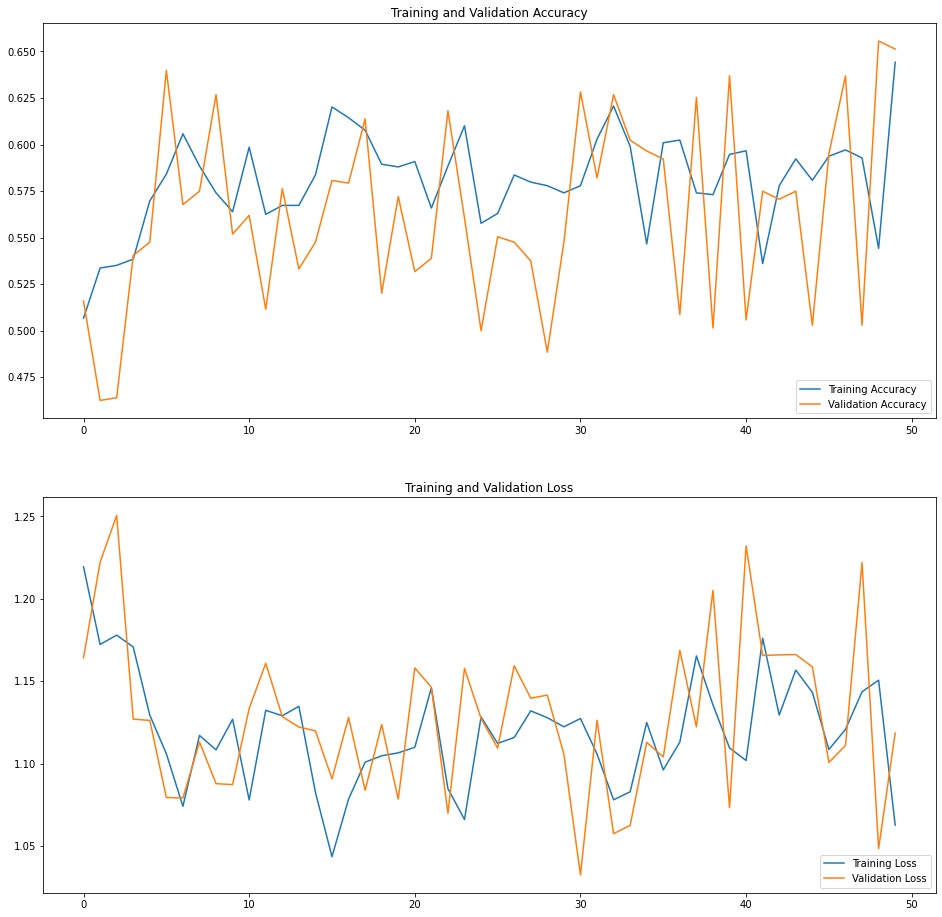

In [161]:
drop_param(.01)

C:\Users\Hydro\AppData\Local\Temp/ipykernel_14408/799181565.py:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_drop = model_drop.fit_generator(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)


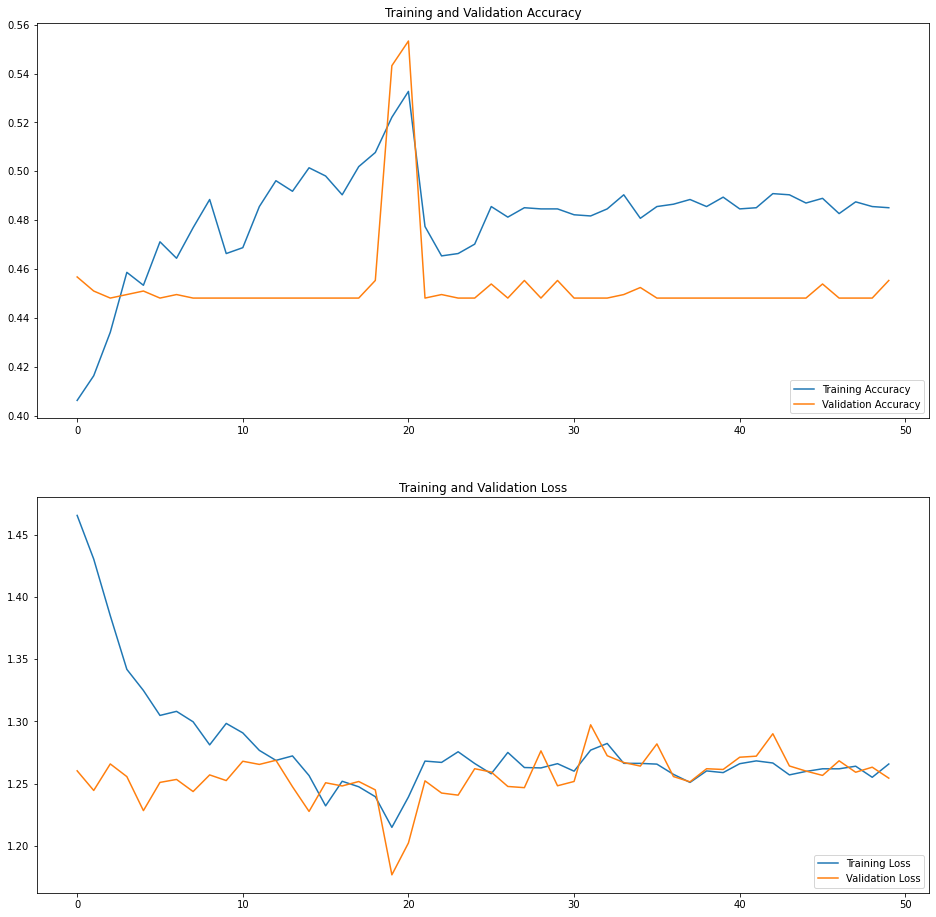

In [164]:
drop_param(0.5)

It appears that the lower the dropout value, the large disparity between training and validation is. The loss likewise remains relatively unchanged unless in upper limit drop values `(0.999)`. As such, we will use the dropout value `0.1` as we progress in tuning the model.

We will now adjust some of the base model parameters. Namely, the number of hidden layers and the number hidden layers present in the model. We will observe the reuslts and whether the accuracy and loss functions have improved.

C:\Users\Hydro\AppData\Local\Temp/ipykernel_14408/355731372.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_hidden = shape_model_hidden.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


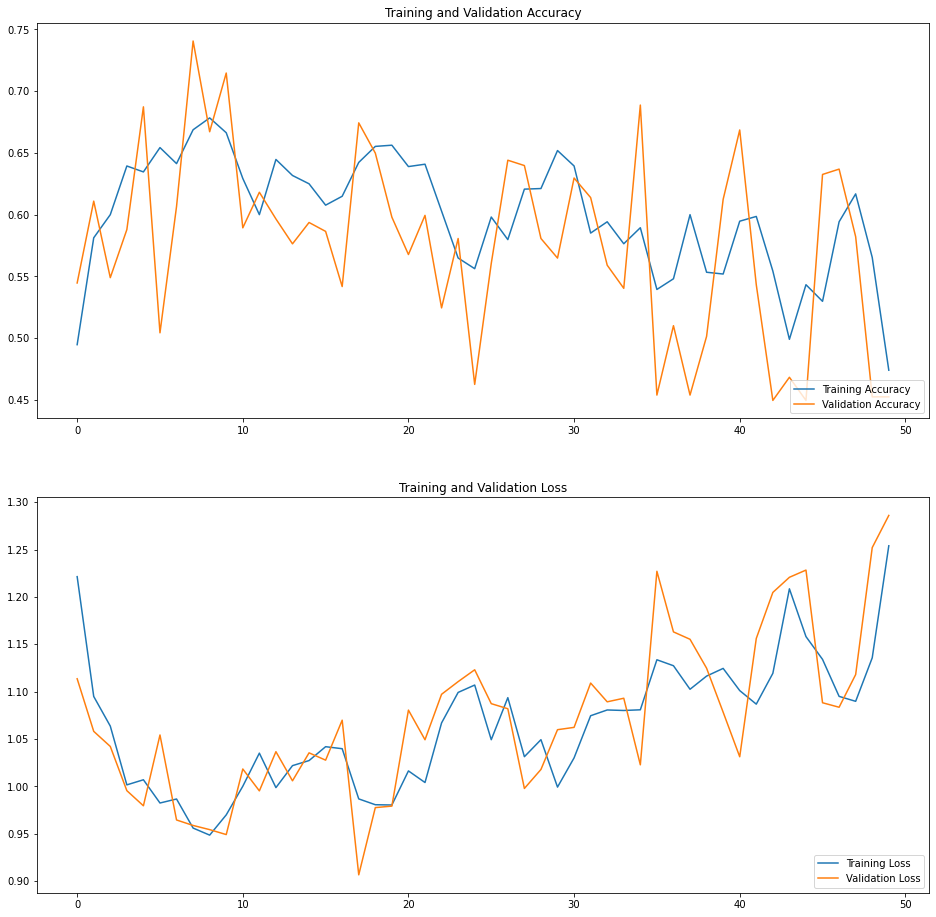

In [188]:
HIDDEN_LAYER_DIM = 512


shape_model_hidden = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=INPUT_DIM),
tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
tf.keras.layers.Dense(OUTPUT_CLASSES)])

shape_model_hidden.compile(optimizer='SGD',
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['categorical_accuracy'])

history_hidden = shape_model_hidden.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

plot_learning_curve(history_hidden)

By expanding the hidden layer neuron amount to 512, we obtain a higher accuracy score, within a range between `0.55-0.65`. The graph on loss likewise follows the same trend, with a relatively lower loss score in comparison to the base model. One thing to note however is the general trend that can be interpreted from the graphs. The accuracy for both training and validation gradually decrease.

C:\Users\Hydro\AppData\Local\Temp/ipykernel_14408/267658488.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_hidden = shape_model_hidden.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)


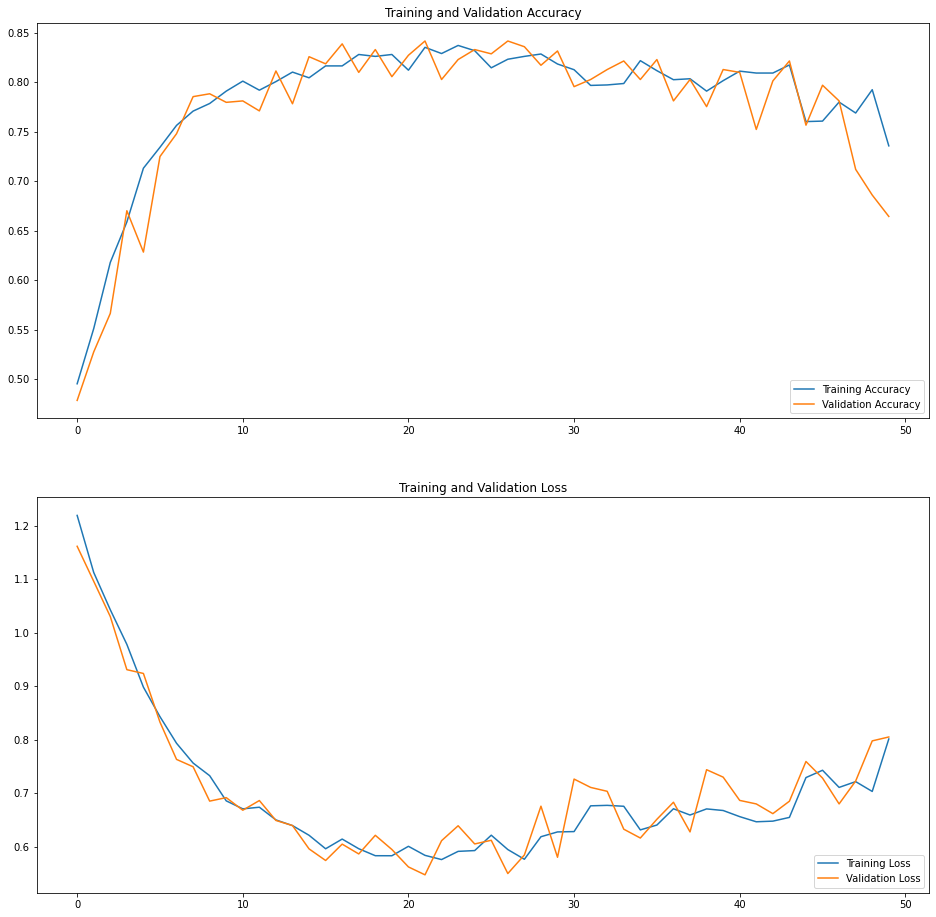

In [189]:
shape_model_hidden = tf.keras.Sequential([
tf.keras.layers.Flatten(input_shape=INPUT_DIM),
tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
tf.keras.layers.Dense(OUTPUT_CLASSES)])

shape_model_hidden.compile(optimizer='SGD',
            loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
            metrics=['categorical_accuracy'])

history_hidden = shape_model_hidden.fit_generator(train_generator, validation_data = validation_generator, epochs=50, verbose=0)

plot_learning_curve(history_hidden)

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1

# Here the validation is used for testing and this should be changes to a separate test set.
test_generator = train_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./',
        x_col="ImgPath",
        y_col="Shape",
        target_size=(28, 28),
        batch_size=batch_size_t,
        class_mode='categorical')



In [ ]:
shape_model.evaluate(test_generator)

In [ ]:
label_names = {'diamond' : 0, 'hex' : 1, 'round' : 2, 'square' : 3, 'triangle' : 4}

d_inv = {v: k for k, v in label_names.items()}

plt.figure(figsize=(16,4))
batches = 0

for x,y in test_generator:
    # print(x)
    # print(y)
    batches = batches + 1
    y_hat = shape_model.predict(x)
    x = np.squeeze(x)
    if batches < 5:
        plt.subplot(1,5,batches)
        plt.imshow((x * 255).astype(np.uint8))
        plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
        print(
            "This image most likely belongs to {}."
            .format(d_inv[np.argmax(y_hat[0])])
        )
    else:
        break
    
    plt.axis('off')